Time Series Analysis - Coursework 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import toeplitz

In [2]:
# Q1(a)
def ar4_sim(N, f1, f2, r1, r2, sigma_squared, burn_in=1000):
    
    # Generate white noise in one step instead of computing everytime in for loop
    white_noise = np.random.normal(0, np.sqrt(sigma_squared), N + burn_in)

    # Ceofficients of characteristic equation
    phis = np.array([2*r1*np.cos(2*np.pi*f1) + 2*r2*np.cos(2*np.pi*f2), 
                  -1*((r1**2) + (r2**2) + 2*r1*r2*(np.cos(2*np.pi*(f1-f2))) + \
                    2*r1*r2*(np.cos(2*np.pi*(f1+f2)))),
                  2*(r1**2)*r2*(np.cos(2*np.pi*(f2))) + 2*(r2**2)*r1* \
                    (np.cos(2*np.pi*(f1))), 
                  -1 * (r1**2) * (r2**2)])

    # Initialise AR(4) process and initialise first 4 terms
    ar_process = np.zeros(N + burn_in)
    ar_process[0:4] = [0 for i in range(4)]
    
    # Compute process
    for i in range(4, N + burn_in):
        ar_process[i] = np.dot(phis, ar_process[i-4:i]) + white_noise[i]

    # Discard burn-in values
    ar_process = ar_process[burn_in:]

    return ar_process, phis

To compute the parameters of the AR(4) process, I took the characteristic equation $\Phi(z) = 1-\phi _ {1,4}z - \phi _ {2,4}z^2 - \phi _{3,4}z^3 - \phi _{4,4}z^4$ and took the roots to be $z_1=\frac{1}{r_1}e^{i2\pi f_1}, z_2=\frac{1}{r_2}e^{i2\pi f_2}$ and $z_3 = z_1 ^*, z_4=z_2 ^*$ (complex conjugates of $z_1$ and $z_2$). Then, I rewrote the characteristic polynomial in terms of the product of the roots $\Phi(z) = (1-az)(1-bz)(1-cz)(1-dz)$ where $z_1 = \frac{1}{a}, z_2 = \frac{1}{b}, z_3 = \frac{1}{c}$ and $z_4 = \frac{1}{d}$ are the $4$ roots. After expanding the the brackets, I obtained the parameters $(\phi _ {1,4}, \phi _{2,4}, \phi _{3,4}, \phi _{4,4})$ in terms of $a,b,c$ and $d$, and therefore in terms of $r_1, r_2, f_1, f_2$.

In [3]:
# Q1(b)
def S_AR(f,phis, sigma2):
    p = len(phis)  

    # Compute the numerator of the spectral density function
    numerator = sigma2

    # Compute the denominator of the spectral density function
    vals = np.exp(-2j * np.pi * f)
    # Initialise spectral density
    spectral_density = np.zeros(len(f))
    
    for i in range(len(f)):
        # Obtain values for characteristic polynomial
        x = vals[i] ** np.arange(1, p+1)
        denominator = np.abs(1 - np.dot(phis, x))
        # Compute the spectral density function
        spectral_density[i] = numerator / denominator**2
    
    # Return f and ans, easier to plot if f is 
    # Reorder spectral density and frequencies to get 0th frequency in the center
    return np.fft.fftshift(f), np.fft.fftshift(spectral_density)


In [4]:
# Q1(c)
def periodogram(X):
    N = len(X)
    # Calculate the sample frequencies up to 0.5 (down to -0.5)
    frequencies = np.fft.fftfreq(N, d=1)
    # Calculate Fourier transform of data points
    fft_vals = np.fft.fft(X)
    # Compute the periodogram
    p_gram = np.abs(fft_vals) ** 2 / N
    # Reorder periodogram and frequencies to get 0th frequency in the center
  
    return np.fft.fftshift(frequencies), np.fft.fftshift(p_gram)

In [5]:
def direct(X, p):
    N = len(X)
    # Useful variables to store
    ind = int((p*N)//2)
    pN = int(p*N)
    # Intialise taper
    taper = np.zeros(N)
    for i in range(ind):
        taper[i] = 0.5 * (1-np.cos(2*np.pi*(i+1)/(pN+1)))
    for i in range(ind, N-ind):
        taper[i] = 1
    for i in range(N-ind, N):
        taper[i] = 0.5 * (1-np.cos(2*np.pi*(N-i)/(pN+1)))
    C = np.dot(taper, taper)
    taper /= C
    
    # Calculate periodogram of tapered series
    p_gram = periodogram(X*taper)
    return p_gram[0], p_gram[1] * N

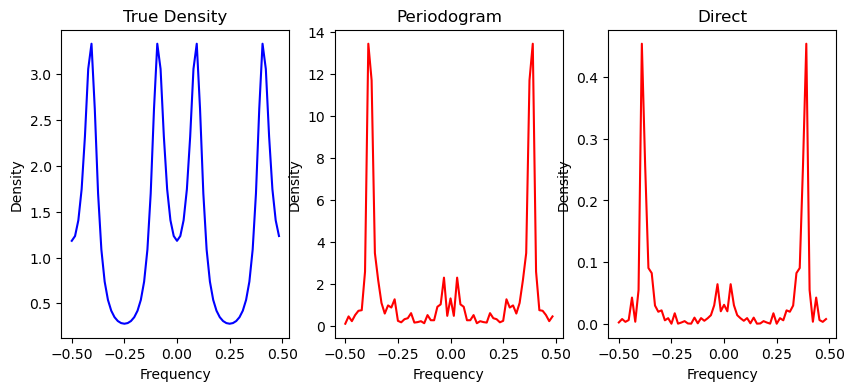

In [6]:
# testing functions (not a specific question on the coursework)
N = 64
f1 = 6/64
f2 = 26/64
r1 = 0.8
r2 = 0.8
sigma_squared = 1
X, phis = ar4_sim(N, f1, f2, r1, r2, sigma_squared)
frequencies = np.fft.fftfreq(N, d=1)
true_spectral = S_AR(frequencies, phis, sigma_squared)
periodogram_1= periodogram(X)
direct_1 = direct(X, 0.5)
fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 3 columns

# Plot the first subplot
axs[0].plot(true_spectral[0], true_spectral[1], color='blue')
axs[0].set_title('True Density')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Density')

# Plot the second subplot
axs[1].plot(periodogram_1[0], periodogram_1[1], color='red')
axs[1].set_title('Periodogram')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Density')

# Plot the third subplot
axs[2].plot(direct_1[0], direct_1[1], color='red')
axs[2].set_title('Direct')
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Density')



plt.show()

In [119]:
# Q1(d)
N = 64
f1 = 6/64
f2 = 26/64
r1 = 0.8
r2 = 0.8
sigma_squared = 1
# vals stores all simulations for each freq and each estimator (4 of them)
# including true spectral
vals = np.zeros((5000, 5, 4))
# for every r, calculate sample bias
pbias = np.zeros((20, 5, 4))

for r in range(0,20):
    r1, r2 = 0.01*r +0.8, 0.01*r +0.8
    vals = np.zeros((5000, 5, 4))
    for i in range(5000):
        
        X, phis = ar4_sim(N, f1, f2, r1, r2, sigma_squared)
        frequencies = np.fft.fftfreq(N, d=1)
        # Only need to calculate the true spectral density once as
        # phis are only calculated once
        if i == 0:
            # store corresponding frequencies
            true_spectral = S_AR(frequencies, 
                                 phis, sigma_squared)[1][[38, 40, 48, 58]]
        periodogram_1= periodogram(X)
        direct_1 = direct(X, 0.05)
        direct_2 = direct(X, 0.1)
        direct_3 = direct(X, 0.25)
        direct_4 = direct(X, 0.5)
        vals[i, 0, :] = periodogram_1[1][[38, 40, 48, 58]]
        vals[i, 1, :] = direct_1[1][[38, 40, 48, 58]]
        vals[i, 2, :] = direct_2[1][[38, 40, 48, 58]]
        vals[i, 3, :] = direct_3[1][[38, 40, 48, 58]]
        vals[i, 4, :] = direct_4[1][[38, 40, 48, 58]]
    # average over the 5000 iterations for each freq and each \
    # estimator and compute sample percentage bias
    pbias[r, :, :] = np.abs(np.mean(vals[:,:, :], axis=0) - \
                      true_spectral) * 100 / true_spectral
        

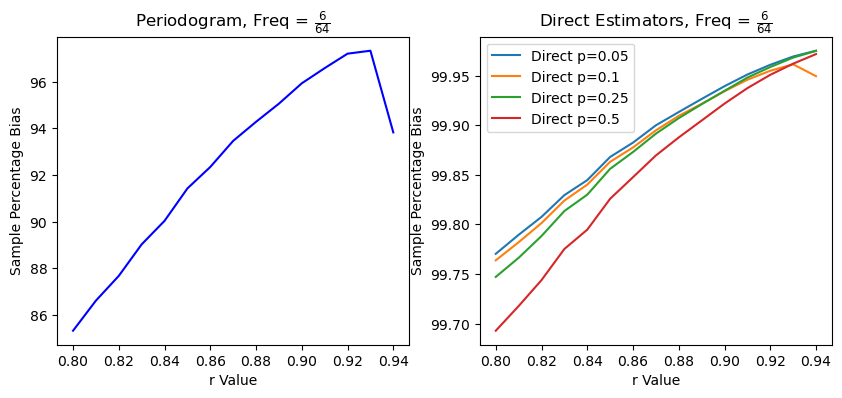

In [146]:
r_vals = np.arange(0.8,1,0.01)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the first subplot
freq = r"$\frac{6}{64}$"
axs[0].plot(r_vals[:15], pbias[:15, 0, 0], color='blue')
axs[0].set_title(f"Periodogram, Freq = {freq}")
axs[0].set_xlabel('r Value')
axs[0].set_ylabel('Sample Percentage Bias')

# Plot the second subplot
axs[1].plot(r_vals[:15], pbias[:15,1:, 0])
axs[1].set_title(f'Direct Estimators, Freq = {freq}')
axs[1].set_xlabel('r Value')
axs[1].set_ylabel('Sample Percentage Bias')
plt.legend(["Direct p=0.05", "Direct p=0.1", \
            "Direct p=0.25", "Direct p=0.5"])

plt.show()

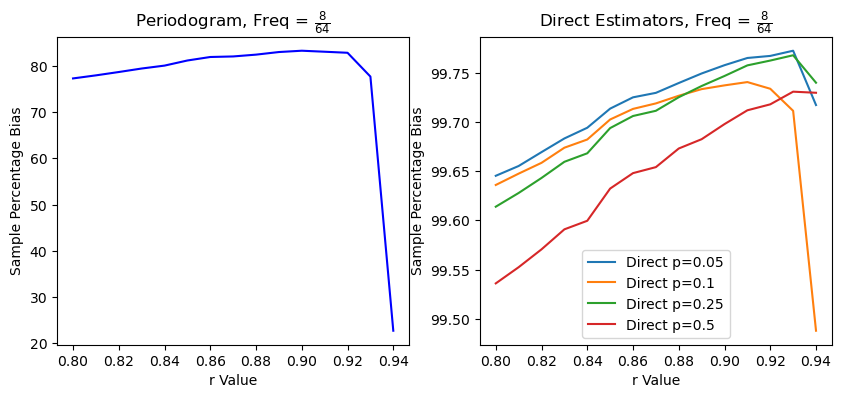

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the first subplot
freq = r"$\frac{8}{64}$"
axs[0].plot(r_vals[:15], pbias[:15, 0, 1], color='blue')
axs[0].set_title(f"Periodogram, Freq = {freq}")
axs[0].set_xlabel('r Value')
axs[0].set_ylabel('Sample Percentage Bias')

# Plot the second subplot
axs[1].plot(r_vals[:15], pbias[:15,1:, 1])
axs[1].set_title(f'Direct Estimators, Freq = {freq}')
axs[1].set_xlabel('r Value')
axs[1].set_ylabel('Sample Percentage Bias')
plt.legend(["Direct p=0.05", "Direct p=0.1", \
            "Direct p=0.25", "Direct p=0.5"])

plt.show()

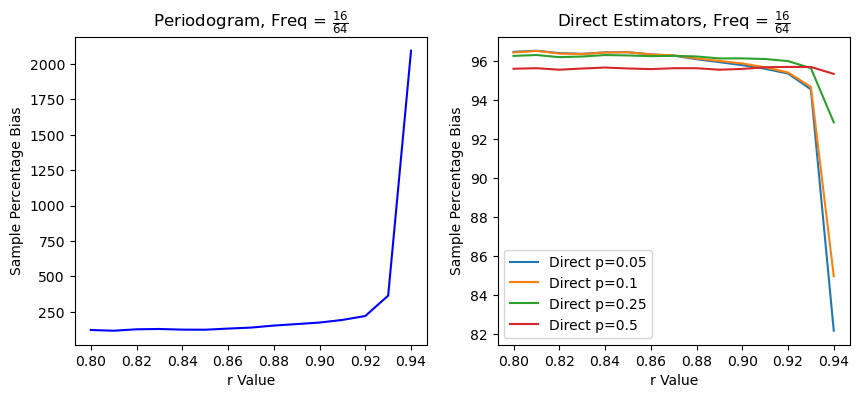

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the first subplot
freq = r"$\frac{16}{64}$"
axs[0].plot(r_vals[:15], pbias[:15, 0, 2], color='blue')
axs[0].set_title(f"Periodogram, Freq = {freq}")
axs[0].set_xlabel('r Value')
axs[0].set_ylabel('Sample Percentage Bias')

# Plot the second subplot
axs[1].plot(r_vals[:15], pbias[:15,1:, 2])
axs[1].set_title(f'Direct Estimators, Freq = {freq}')
axs[1].set_xlabel('r Value')
axs[1].set_ylabel('Sample Percentage Bias')
plt.legend(["Direct p=0.05", "Direct p=0.1", \
            "Direct p=0.25", "Direct p=0.5"])

plt.show()

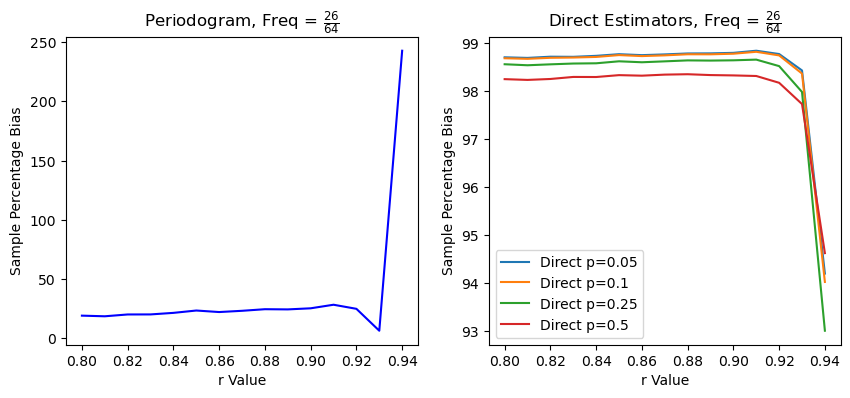

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the first subplot
freq = r"$\frac{26}{64}$"
axs[0].plot(r_vals[:15], pbias[:15, 0, 3], color='blue')
axs[0].set_title(f"Periodogram, Freq = {freq}")
axs[0].set_xlabel('r Value')
axs[0].set_ylabel('Sample Percentage Bias')

# Plot the second subplot
axs[1].plot(r_vals[:15], pbias[:15,1:, 3])
axs[1].set_title(f'Direct Estimators, Freq = {freq}')
axs[1].set_xlabel('r Value')
axs[1].set_ylabel('Sample Percentage Bias')
plt.legend(["Direct p=0.05", "Direct p=0.1", \
            "Direct p=0.25", "Direct p=0.5"])

plt.show()

Q1(e)

For $3$ of the frequencies, the periodogram seems to do better than the direct estimators. One reason for this is that the direct estimators widen the main lobe of the spectral estimate. This overestimates the frequency at certain points, causing the bias to increase. For $r$ values greater than $0.94$, the bias seems to deviate massively and the estimates are far off the spectral density. In general, for as the we increase the frequency away from the oscillating frequency, the $r$ value for which the bias starts to deviate gets smaller.

In [87]:
# Q2
data = pd.read_excel(r"C:/Users/rijul/Downloads/00081.xlsx", header=None)
ts = np.array(data.iloc[:,1])
centered_ts = ts - np.mean(ts)

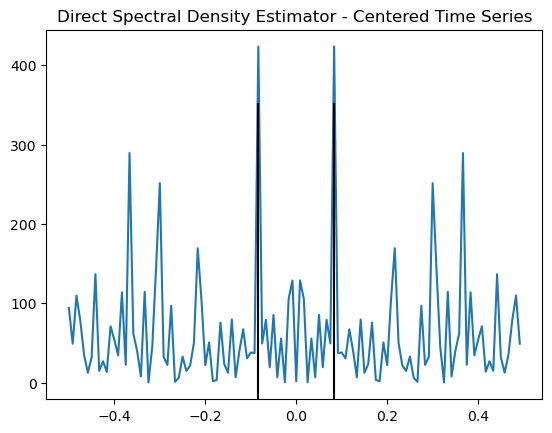

In [88]:
ts_direct = direct(centered_ts, 0.25)
plt.plot(ts_direct[0], ts_direct[1])
plt.title("Direct Spectral Density Estimator - Centered Time Series")
plt.axvline(1/12, color = "black", ymax=0.8)
plt.axvline(-1/12, color = "black", ymax=0.8)
plt.show()

This data is taken from the National Oceanographic Centre’s repository and contains data from 10 years of monthly sea level gauge data from a given buoy collected from Wismar, Germany. One coloumn of the data is the time in years, the other coloumn is recorded in millimeters. This data specifically is taken from 2009 till 2019. 

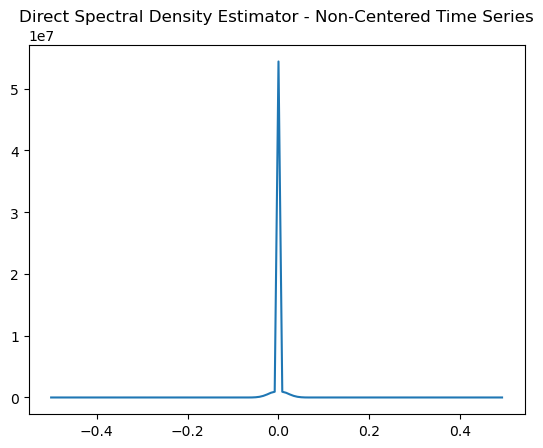

In [158]:
ts_direct = direct(ts, 0.25)
plt.plot(ts_direct[0], ts_direct[1])
plt.title("Direct Spectral Density Estimator - Non-Centered Time Series")
plt.show()

From the centered time series density estimate plot, we see multiple peaks at different frequencies. The prominent peaks occur at a frequency of $|\frac{1}{12}|$ (black lines on the graph), representing correlation between sea levels on a yearly basis. There are other less dominant peaks at higher frequencies which could represent more longer term behaviour to do with temperature cycles on Earth. 

The non-centered time series density appears to have only one dominant peak frequency around $0$. This is because $S(0) = \sum_{\tau=-\infty}^{\infty}s_\tau$, where for a given $\tau$, $s_\tau = E(X_tX_{t+\tau}) - E(X_t)E(X_{t+\tau})$. By stationarity, $s_\tau = E(X_0X_{\tau}) - \mu ^2$. After noticing that the observed $X_0$ in the time series is much smaller than the mean of the time series, we see that $s_\tau$ gets very big and dominates the other frequencies in the spectrum.

In [170]:
# Q3(a)
# Functions for Yule Walker method
def sample_autocovariance(ts, lag):
    N = len(ts)
 
    if lag == 0:
        return np.dot(ts,ts) / N
    
    return np.dot(ts[:-lag], ts[lag:]) / N

def autocovariance_matrix(ts, max_lag):
    autocovariances = [sample_autocovariance(ts, lag) for lag in range(max_lag + 1)]
    gam = autocovariances[1:]
    return toeplitz(autocovariances[:-1]), gam

def yule_walker_parameters(ts, max_lag):
    autocov_matrix, autocov_vector = autocovariance_matrix(ts, max_lag)
    return np.linalg.solve(autocov_matrix, autocov_vector), autocov_matrix[0, 0], autocov_vector

def variance_estimator(ts, max_lag):
    ar_parameters, s0, autocov_vector = yule_walker_parameters(ts, max_lag)
    return s0 - np.dot(ar_parameters, autocov_vector)

In [177]:
# Functions for ML method
def generate_data_matrix(ts, p):
    # Generate data matrix
    N = len(ts)
    F = np.column_stack([ts[p - i - 1 : N - i - 1] for i in range(p)])
    return F

def ml_parameters(ts, p):
    # Estimate phis from ML method
    F_mat = generate_data_matrix(ts, p)
    X = ts[p:]
    phis = np.linalg.lstsq(F_mat, X, rcond=None)[0]
    residuals = X - np.dot(F_mat, phis)
    sigma = np.dot(residuals, residuals) / (N - (2 * p))
    return phis[::-1], sigma

In [238]:
# Fine squared error
def se_X(X, p, m, parameters):
    return (X[m] - (np.dot(parameters, X[m-p:m])))**2

# Function to find optimal P
def optimal(P = 10, MLE = False):
    errors = []
    for p in range(2, P+1):
        p_list = []
        for m in range(60, 119):
            if MLE:
                # print(m)
                parameters = yule_walker_parameters(centered_ts, p)[0]
            else:
                parameters = ml_parameters(centered_ts, p)[0]
            p_list.append(se_X(centered_ts, p, m, parameters))
        # Calcute RMSE
        errors.append(np.mean(p_list)**0.5)
    error_dict = dict(zip(range(2, P+1), errors))
    markdown_table = "| P Value | RMSE |\n|----|------|\n"
    for key, values in error_dict.items():
        markdown_table += f"| {key} | {values} | \n"
    print(markdown_table)


print("RMSE - Yule-Walker")
optimal(MLE = False)
print("RMSE - ML")
optimal(MLE = True)

RMSE - Yule-Walker
| P Value | RMSE |
|----|------|
| 2 | 70.40929831161222 | 
| 3 | 68.8074277025312 | 
| 4 | 68.47939341077848 | 
| 5 | 67.57889208596197 | 
| 6 | 67.82787114655554 | 
| 7 | 67.158955743462 | 
| 8 | 67.21454400909562 | 
| 9 | 67.20208415482095 | 
| 10 | 64.90432645505072 | 

RMSE - ML
| P Value | RMSE |
|----|------|
| 2 | 70.8480240114894 | 
| 3 | 70.18780144474387 | 
| 4 | 69.68288710202029 | 
| 5 | 72.89361269149542 | 
| 6 | 78.08339021742721 | 
| 7 | 78.59088707533124 | 
| 8 | 77.51054626188268 | 
| 9 | 78.46649020587803 | 
| 10 | 72.33894795141963 | 



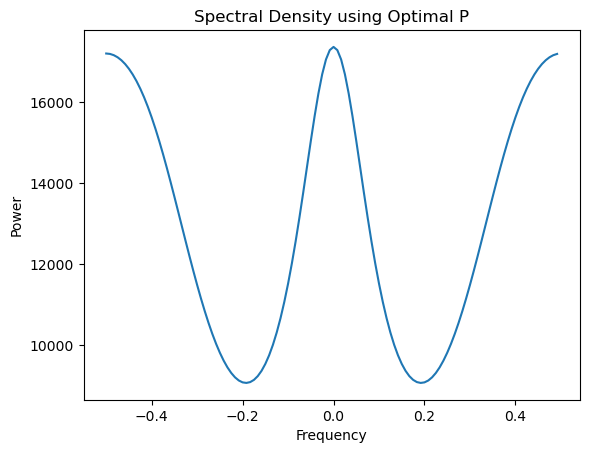

In [240]:
# Q3(b)
# The corresponding lowest p value with lowest RMSE is 4 (from table above)
p = 4
phis, sigma_est = ml_parameters(centered_ts, p)
frequencies = np.fft.fftfreq(len(centered_ts), d=1)
spec_dense = S_AR(frequencies, phis, sigma_est)
plt.title("Spectral Density using Optimal P")
plt.plot(spec_dense[0], spec_dense[1])
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()


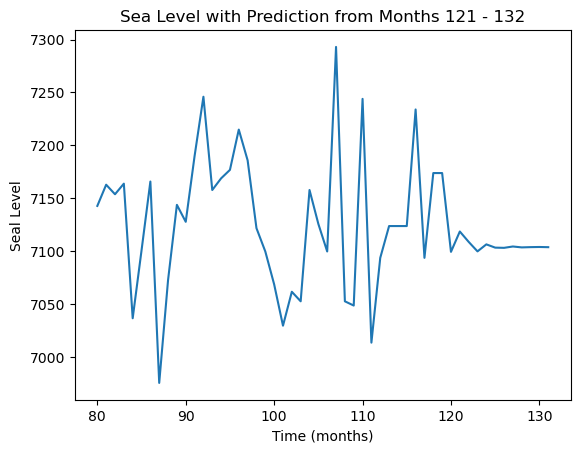

In [241]:
# Q3(c)
# Forecast next 12 months 
def forecast(phis, x, m=12):
    p = len(phis)
    y = x.copy()

    for i in range(m):
        forecasted_value = np.dot(phis, y[-p:])
        y = np.append(y, forecasted_value)

    return y[len(x):]

y_forecast = forecast(phis, centered_ts, m=12)
vals_80 = centered_ts[80:]
prediction = np.concatenate((vals_80, y_forecast), axis=None) + np.mean(ts)
time = np.arange(80, 132, 1)
plt.plot(time, prediction)
plt.xlabel("Time (months)")
plt.ylabel("Seal Level")
plt.title("Sea Level with Prediction from Months 121 - 132")
plt.show()

In [242]:
# Q3(d)
def compute_residuals(x, phis):
  
    p = len(phis)
    n = len(x)
    # real value minus forecasted value
    residuals = [x[i + p] - np.dot(phis, x[i : i + p]) for i in range(n - p)]
    return residuals

def compute_sd_eps(residuals):
    l = 12
    sd_eps = np.zeros(l)
    for i in range(1, l):
        sd_eps[i] = np.std(residuals) * np.sqrt(i)
    return sd_eps

def compute_prediction_interval(y, sd_eps, confidence=1.96):
    # Find confidence intervals
    upper = y + confidence * sd_eps + np.mean(ts)
    lower = y - confidence * sd_eps + np.mean(ts)
    return upper, lower

l_value = 12
epsilon_residuals = compute_residuals(centered_ts, phis)
sd_eps_values = compute_sd_eps(epsilon_residuals)


# Compute the 95% prediction interval
upper_bound, lower_bound = compute_prediction_interval(y_forecast, sd_eps_values, confidence=1.96)


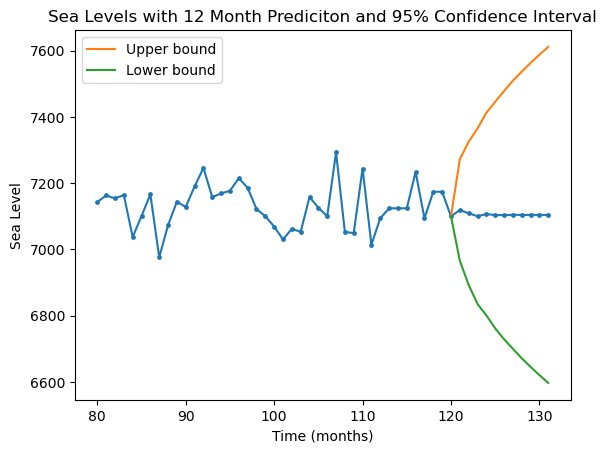

In [243]:

plt.scatter(time, prediction, s=6)
plt.plot(time, prediction,)
plt.plot(np.arange(120, 132, 1), upper_bound, label='Upper bound')
plt.plot(np.arange(120, 132, 1), lower_bound, label='Lower bound')
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Sea Level")
plt.title("Sea Levels with 12 Month Prediciton and 95% Confidence Interval")
plt.show()

Q3(e)

For larger values of $p$, we see that the predicted values vary more around the mean, when compared to $p=4$. The confidence interval for predict points seems to vary more as well, and the confidence intervals tightens randomly at points.